In [38]:
######################################################################
######################### 댓글 크롤링 시작 ############################
######################################################################

import urllib.parse as rep
import urllib.request as req
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
import gzip
import pandas as pd
import json
import time
import pandas as pd

In [34]:


# Header 정보 초기화
opener = req.build_opener()
# User-Agent 정보
#opener.addheaders = [('User-agent', UserAgent())]
# Header 정보 삽입
req.install_opener(opener)

# 쇼핑 댓글 요청 헤더
# https://search.shopping.naver.com/catalog/24178126692?cat_id=50000814&nv_mid=24178126692&NaPm=ct%3Dkmochwcg%7Cci%3D5fbcf90319f44a9577a7ba53d9afec4cf0af44e8%7Ctr%3Dsl%7Csn%3D95694%7Chk%3D180c476dc3ec1764ae9d356ee403773d5f2382ca
# https://search.shopping.naver.com/catalog/14742158672?NaPm=ct%3Dkmyyltb4%7Cci%3D8fb2739c338be12299472ccff160ded9bc19122f%7Ctr%3Dslsl%7Csn%3D95694%7Chk%3D0186b9292ab060733115318dcfd65d3aefb527b7

    
# Request
flag = True
pageNum = 1
result = []
count = 0
while flag:
    
    print(len(result))
    # Throttle 설정
    time.sleep(0.7)
    try:
        
        # 쇼핑 댓글 요청 헤더
        hdr = {'authority': 'search.shopping.naver.com', \
        'method': 'GET',\
        'path': '/review?nvMid=14742158672&reviewType=ALL&sort=QUALITY&isNeedAggregation=N&isApplyFilter=N&page='+str(pageNum)+'&pageSize=20',\
        'scheme': 'https',\
        'accept': 'application/json, text/plain, */*',\
        'accept-encoding': 'gzip, deflate, br',\
        'accept-language': 'ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7',\
        'cache-control': 'no-cache',\
        'pragma': 'no-cache',\
        'referer': 'https://search.shopping.naver.com/catalog/14742158672?NaPm=ct%3Dkmyyltb4%7Cci%3D8fb2739c338be12299472ccff160ded9bc19122f%7Ctr%3Dslsl%7Csn%3D95694%7Chk%3D0186b9292ab060733115318dcfd65d3aefb527b7',\
        'sec-ch-ua': '"Google Chrome";v="89", "Chromium";v="89", ";Not A Brand";v="99"',\
        'sec-ch-ua-mobile': '?0',\
        'sec-fetch-dest': 'empty',\
        'sec-fetch-mode': 'cors',\
        'sec-fetch-site': 'same-origin',\
        'urlprefix': '/api',\
        'user-agent': 'M'}

        url = 'https://search.shopping.naver.com/review?nvMid=14742158672&reviewType=ALL&sort=QUALITY&isNeedAggregation=N&isApplyFilter=N&page='+str(pageNum)+'&pageSize=20'        
        
        reqeust = req.Request(url,headers=hdr)
        res = gzip.decompress(req.urlopen(reqeust).read()).decode('utf-8')
        
        data = json.loads(res)
        result.extend(data['reviews'])
        pageNum = pageNum + 1
        
        
    
    except Exception as e:
        
        # Too many request (429) 일 때 sleep 후 다시 요청
        if e.code == 429:
            print("429 error is occured")
            time.sleep(60)
        else:
            print(str(e))
            print('더 없음')
            flag = False


#res = req.urlopen(reqeust).read().decode('utf-8')



0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
429 error is occured
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
429 error is occured
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
2400
2420
2440
2460
2480
2500
2520
2540
2560
2580
2600
2620
2640
2660
2680
2700
2720
2740
2760
2780
2800
2820
2840
2860
2880
2900
2920
2940
2960
2980
3000
3020
3040
3060
3080
3100
3120
3140
3160
3180
3200
3220
429 error is occured
3220
3240
3260
3280
3300
3320
3340
3360
3380
3400
3420
3440
3460
3480
3500
3520
3540
3560
3580
3600
3620
3640
3660
3680
3700
3720
3740
3760
3780
3800
3820
3840
3860
3880
3900

AttributeError: 'JSONDecodeError' object has no attribute 'code'

In [37]:


####################################################################################
######################## 저장된 크롤링 데이터 불러오기 ###############################
####################################################################################

df = pd.DataFrame(result)
#df = pd.read_csv('review_data.csv')
#df.to_csv('review_data.csv',sep=',', na_rep='NaN')
df.describe

<bound method NDFrame.describe of        mallId mallProductId updateType mallReviewId mallSeq        nvMid  \
0        evas     450072517     UPSERT    884568151  196900  10110341669   
1     lgeshop      21606783     UPSERT    159716221       1  22167213896   
2     lgeshop      21606783     UPSERT    161640758       1  22167213896   
3     lgeshop      21606783     UPSERT    161686778       1  22167213896   
4        evas     450072517     UPSERT    884651289  196900  10110341669   
...       ...           ...        ...          ...     ...          ...   
9995     evas    1001672838     UPSERT    309754686  196900  11546159588   
9996     evas    1001672838     UPSERT    309890694  196900  11546159588   
9997     evas    1001672838     UPSERT    307403606  196900  11546159588   
9998     evas     450072517     UPSERT    310322696  196900  10110341669   
9999     evas    1001672838     UPSERT    309654414  196900  11546159588   

       matchNvMid    userId  \
0     14742158672  khs

In [39]:
len(result)

10000

In [40]:
result[6]

{'mallId': 'goodsdaq',
 'mallProductId': '1416294630',
 'updateType': 'UPSERT',
 'mallReviewId': '106684740',
 'mallSeq': '24',
 'nvMid': '19131673418',
 'matchNvMid': '14742158672',
 'userId': 's*8*****',
 'title': '향이 강하네요',
 'content': '<em>다른분 말처럼 향이 강하네요</em>발랐을때 깔끔한 느낌보다는 살짝 텁텁한 느낌이었어요 그렇다고 끈적이거나 그런건 아니지만 개운~깔끔하지는 않았어요.. 진정토너라해서 기대를 너무한건가요.......?진정효과는 두번째치고 볼은 열감으로 발그레되고 좁쌀같이 올라오고.. 건조하기까지.. 아침에 얼굴 당겨 거울봤다가 놀랬어요 땡기는 피부팩한줄.. 팩하고 굳었을때 웃으면 주름 생기듯 얼굴 근육에 따라 줄이 생기며 구겨지는데.. 이건 나랑은 아닌듯 싶네요..(토너+수분크림+팩 여기꺼만 사용)',
 'registerDate': '2021-03-17',
 'modifyDate': '2021-05-04',
 'pageUrl': 'http://item2.gmarket.co.kr/Item/detailview/Item.aspx?goodscode=1416294630',
 'createTime': 1621408774488,
 'qualityScore': 0.791547,
 'starScore': 1,
 'imageYn': 'N',
 'imageCount': 0,
 'videoYn': 'N',
 'videoCount': 0,
 'topicYn': 'Y',
 'topicCount': 1,
 'topics': [{'topicCode': 'smell',
   'topicName': '향기',
   'topicNameRaw': '향기',
   'startPosition': 0,
   'endPosition': 38,
   'reputationScore': 584,


In [41]:
######################################################################
######################### 댓글 크롤링 끝 ##############################
######################################################################

print(df.iloc[0]['content'])

쑥 들어간 <em>제품들을 평소에 좋아해서 </em>쑥 화장품으로 대부분 쓰려고 해요 아침 저녁으로 매일 매일 쓰기에 부담이 없고 좋습니다<br>자연약쑥 진정 토너라 자극없이 쓰기에도 좋고 녹차 루이보스 캐모마일 쑥 페퍼민트 로즈마리 유칼리투스잎이 들어간 그린 허브 성분이라 피부 진정에도 도움이 되는거 같아요


In [55]:
######################################################################
######################### 댓글 TextRank ##############################
######################################################################
#!pip install kobert-transformers

     |████████████████████████████████| 2.2 MB 693 kB/s 
     |████████████████████████████████| 127.9 MB 7.7 MB/s 
     |████████████████████████████████| 895 kB 4.5 MB/s 
     |████████████████████████████████| 2.2 MB 12.7 MB/s 


In [42]:
#형태소 분석기 Komoran

from konlpy.tag import Komoran

komoran = Komoran()
sent = '쑥 들어간 제품들을 평소에 좋아해서 쑥 화장품으로 대부분 쓰려고 해요 아침 저녁으로 매일 매일 쓰기에 부담이 없고 좋습니다자연약쑥 진정 토너라 자극없이 쓰기에도 좋고 녹차 루이보스 캐모마일 쑥 페퍼민트 로즈마리 유칼리투스잎이 들어간 그린 허브 성분이라 피부 진정에도 도움이 되는거 같아요'

words = komoran.pos(sent, join=True)
print(words )


['쑥/MAG', '들어가/VV', 'ㄴ/ETM', '제품/NNG', '들/XSN', '을/JKO', '평소/NNG', '에/JKB', '좋아하/VV', '아서/EC', '쑥/MAG', '화장품/NNG', '으로/JKB', '대부분/NNG', '쓰/VV', '려고/EC', '하/VV', '아요/EC', '아침/NNG', '저녁/NNG', '으로/JKB', '매일/MAG', '매일/MAG', '쓰/VV', '기/ETN', '에/JKB', '부담/NNG', '이/JKS', '없/VA', '고/EC', '좋/VA', '습니다/EC', '자연/NNG', '약/NNG', '쑥/NNG', '진정/NNP', '토너/NNP', '이/VCP', '라/EC', '자극/NNG', '없이/MAG', '쓰/VV', '기/ETN', '에/JKB', '도/JX', '좋/VA', '고/EC', '녹차/NNP', '루이보스/NNP', '캐모마일/NNP', '쑥/MAG', '페퍼/NNP', '민트/NNP', '로즈마리/NNP', '유칼리투스잎이/NA', '들어가/VV', 'ㄴ/ETM', '그리/VV', 'ㄴ/ETM', '허브/NNP', '성분/NNG', '이/VCP', '라/EC', '피부/NNP', '진정/NNG', '에/JKB', '도/JX', '도움/NNG', '이/JKS', '되/VV', '는/ETM', '거/NNB', '같/VA', '아요/EC']


In [43]:
# cleasing 함수 
import regex as re
def cleasing(text):
    repl =''
    pattern = '([ㄱ-ㅎㅏ-ㅣ]+)' # 자음, 모음 제거
    text = re.sub(pattern= pattern, repl=repl, string=text)
    #pattern = '[^\w\s]' # 특수기호 제거
    pattern = '[^가-히\s]' # 특수기호 제거
    text = re.sub(pattern= pattern, repl=repl, string=text)
    pattern = '<[^>]*>' # html 제거
    text = re.sub(pattern = pattern, repl='',string=text)
    return text
df['length'] = df.content.str.len()
df['clean_content'] = df['content'].map(lambda x: cleasing(x))
df2 = df[ df.length > 30 ] 
df2 = df2['clean_content']
df2


0       쑥 들어간 제품들을 평소에 좋아해서 쑥 화장품으로 대부분 쓰려고 해요 아침 저녁으로...
1       화장품 상자에 한번 더 뽁뽁이  포장으로  꼼꼼하게 담아져 있었고  화장품 용기는 ...
2       대용량에 헐 감동입니다 개는 지인도 팍팍 쓰라고 선물했어요이건 화장솜에 듬뿍 하셔서...
3       아직 사용전인데 오자마자 간병이모님이 머냐고 물어 보셔서 약쑥스킨이라고  하니 한번...
4       프레쥬 진정토너 여름에 시원하게 토너팩 하기 좋아요 향은 쑥 냄새보다는 시트러스계열...
                              ...                        
9985    좋아요 재구맵니다 저번에는 유통기한 거의 다 된거 보내주셨는데 거의 다 쓰고 발견했...
9986                              확실히 양도 많고 구성도 좋네요 만족합니다
9987                                 저렴한가격에  괜찮고좋습니다대박나셔요
9990    잘 받았어요 잘 받았어요  아직 써보진 않았지만 기대됩니다 잘 쓰겠습니다 잘 받았어...
9994    좋아요 대용량이라서 스킨팩하기에 너무 좋아요 개인차는 잇겟지만 향도 괜찮네요 정말 ...
Name: clean_content, Length: 4881, dtype: object

In [44]:
def komoran_tokenizer(sent):
    try:
        words = komoran.pos(sent, join=True)
        #words = [w for w in words if ('/NN' in w or '/XR' in w or '/VA' in w or '/VV' in w)]
        words = [w for w in words if ('/NN' in w )]
    except:
        return [0]
    return words

total_analysis = []

for row in df2:
    try:    
        token_list = komoran_tokenizer(row)
        total_analysis.extend(token_list)
    except:
        #pass
        continue

print(total_analysis)

, '송/NNP', '사용/NNG', '전/NNG', '처음/NNG', '거/NNB', '이벤트/NNP', '가로/NNP', '구매/NNG', '토너/NNP', '원/NNB', '폼/NNG', '클렌징/NNG', '청량감/NNG', '화장/NNP', '솜/NNG', '사용/NNG', '데/NNB', '요/NNP', '건조/NNG', '걱정/NNG', '화장/NNP', '솜/NNG', '팩/NNG', '사용/NNG', '전/NNG', '사용/NNG', '감/NNG', '배/NNG', '송/NNP', '후기/NNG', '처음/NNG', '구매/NNG', '용량/NNG', '진짜/NNG', '사용/NNG', '느낌/NNP', '이예/NNP', '요/NNP', '사용/NNG', '사용/NNG', '전/NNG', '스킨/NNP', '구성/NNG', '구입/NNG', '사용/NNG', '구매/NNG', '구매/NNG', '딸/NNG', '트러블/NNP', '저녁/NNG', '얼굴/NNG', '좋아서/NNP', '다/NNG', '쓰기/NNP', '전/NNP', '구매/NNG', '배/NNG', '송도/NNP', '기존/NNG', '제품/NNG', '사용/NNG', '쑥/NNG', '향/NNG', '폼/NNG', '클린/NNP', '징/NNG', '것/NNB', '구매/NNG', '중/NNB', '용량/NNG', '성분/NNG', '거/NNB', '듯/NNB', '해/NNG', '요/NNP', '토너/NNP', '에센스/NNP', '때/NNG', '피부/NNG', '향/NNG', '걱정/NNG', '향/NNG', '사은품/NNG', '폼/NNG', '클렌징/NNG', '성비/NNP', '갑/NNG', '가격/NNP', '대비/NNP', '부담/NNG', '아침저녁/NNG', '안/NNP', '후에/NNP', '수/NNB', '쑥/NNG', '향/NNG', '원래/NNG', '것/NNB', '배/NNG', '송도/NNP', '용량/NNP', '거/NNB', '개/NNB', '

In [214]:
########### 카테고리 정하기 #############

# 명사만 추출한 것
from collections import Counter

count_result = Counter(total_analysis).most_common(300)
print(count_result)

[('사용/NNG', 1399), ('구매/NNG', 1149), ('용량/NNP', 1012), ('향/NNG', 938), ('것/NNB', 741), ('토너/NNP', 740), ('가격/NNG', 662), ('거/NNB', 618), ('쑥/NNG', 519), ('배/NNG', 474), ('향도/NNP', 474), ('스킨/NNP', 432), ('피부/NNG', 429), ('만족/NNG', 416), ('대용량/NNG', 413), ('가격/NNP', 395), ('솜/NNG', 343), ('폼/NNG', 319), ('트러블/NNP', 318), ('수/NNB', 291), ('양도/NNP', 285), ('제품/NNG', 278), ('성비/NNP', 278), ('송/NNP', 273), ('번/NNB', 266), ('화장/NNP', 265), ('클렌징/NNG', 265), ('느낌/NNG', 254), ('양이/NNP', 243), ('피부/NNP', 227), ('냄새/NNG', 226), ('구입/NNG', 225), ('듯/NNB', 221), ('때/NNG', 215), ('부담/NNG', 210), ('얼굴/NNG', 209), ('데/NNB', 208), ('대비/NNP', 208), ('감사/NNG', 200), ('각질/NNG', 198), ('맘/NNG', 196), ('후/NNG', 191), ('쓰기/NNP', 187), ('팩/NNG', 186), ('송도/NNP', 186), ('사은품/NNG', 185), ('요/NNP', 183), ('효과/NNG', 181), ('진정/NNP', 179), ('굿/NNG', 177), ('자극/NNG', 172), ('생각/NNG', 170), ('개/NNB', 169), ('처음/NNG', 168), ('전/NNG', 168), ('좋아서/NNP', 164), ('주문/NNG', 163), ('넘/NNG', 150), ('추천/NNG', 150), ('완전/NNG'

In [216]:
## 카운팅 결과 DataFrame 으로 만들기
df_noun = pd.DataFrame(count_result, columns=['words','feq'])
word_sep =  list(df_noun.words.str.split('/'))
print(word_sep[0][1])
#df_noun['word'] = [ word_sep[i][0] for i in range(len(word_sep)) ]
tmp_list = []
for i in range(len(word_sep)):
    item = word_sep[i][0]
    tmp_list.append(item)

df_noun['word'] = tmp_list
df_noun = df_noun.drop(['words'], axis=1)
df_noun

NNG


,feq,word
0,1399,사용
1,1149,구매
2,1012,용량
3,938,향
4,741,것
...,...,...
295,17,상태
296,17,스프레이
297,17,이정
298,17,이틀


In [149]:
## Transformer 모델 로드하기

import torch
from kobert_transformers import get_kobert_model, get_distilkobert_model
from transformers import BertModel, DistilBertModel

model = BertModel.from_pretrained('monologg/kobert')

print(model.embeddings.word_embeddings[0])
#model = get_kobert_model()
#model.eval()


TypeError: 'Embedding' object is not subscriptable

In [146]:
## 임베딩 치환 테스트
from kobert_transformers import get_tokenizer


tokenizer = get_tokenizer()
tokenizer.tokenize("[CLS] 한국어 모델을 공유합니다. [SEP]")
input_ids = tokenizer.convert_tokens_to_ids(['[CLS]', '▁한국', '어', '▁모델', '을', '▁공유', '합니다', '.', '[SEP]'])
input_ids2 = tokenizer.convert_tokens_to_ids(['[CLS]', '▁한국', '어', '▁모델', '을', '▁공유', '합니다', '.', '[SEP]'])

input_ids2 = tokenizer.convert_tokens_to_ids(['한국'])
input_ids3 = tokenizer.convert_tokens_to_ids(['모델'])
input_ids4 = tokenizer.convert_tokens_to_ids(['구매'])
input_ids5 = tokenizer.convert_tokens_to_ids(['한국'])


#input_ids = torch.LongTensor([input_ids,input_ids2])
input_ids = torch.LongTensor([input_ids2,input_ids3,input_ids4,input_ids5])

print(input_ids)

#attention_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
#token_type_ids = torch.LongTensor([[0, 0, 1], [0, 1, 0]])
#last_hidden_state, pooled_output  = model(input_ids, attention_mask, token_type_ids, return_dict=False)
last_hidden_state, pooled_output  = model(input_ids, return_dict=False)

from scipy import spatial

#print(last_hidden_state[0])
print(last_hidden_state.detach().numpy())
last_hidden_state = last_hidden_state.detach().numpy()
print('--'*20)
result = 1 - spatial.distance.cosine(last_hidden_state[0], last_hidden_state[2])
print(result)
#print(cosine_similarity(last_hidden_state[0],last_hidden_state[1]))


tensor([[7829],
        [6214],
        [   0],
        [7829]])
[[[-0.08377914 -0.4722678  -0.0672182  ... -0.15105821 -0.2903666
   -0.15921444]]

 [[-0.08373912 -0.47229385 -0.06724849 ... -0.1510739  -0.29040048
   -0.15930036]]

 [[-0.08369803 -0.4722603  -0.06729975 ... -0.15118578 -0.29044
   -0.15936404]]

 [[-0.08377914 -0.4722678  -0.0672182  ... -0.15105821 -0.2903666
   -0.15921444]]]
----------------------------------------
0.9999999403953552


In [261]:
## 추출한 명사의 임베딩을 추출함

words_list = [[] for _ in range(len(df_noun.word))]
print(type(df_noun.word))

for i,t in df_noun.word.iteritems():
    tmp_list = []
    tmp_list.append(t)
    words_list[i] = tmp_list
#print(words_list)

## 단어가 있는 임베딩만 치환함
index = 0
words_list_not_zero = []
check_word = []
for i in words_list:
    #print(tokenizer.convert_tokens_to_ids(i)," : ",df_noun.word[index])
    if tokenizer.convert_tokens_to_ids(i)[0] != 0 :
        words_list_not_zero.append(tokenizer.convert_tokens_to_ids(i))
        check_word.append(df_noun.word[index])
        index = index +1 

print(check_word)
print(len(check_word))

input_ids = torch.LongTensor(words_list_not_zero)
last_hidden_state, pooled_output  = model(input_ids, return_dict=False)

sentence_glove = torch.flatten(last_hidden_state, start_dim=1).detach().numpy()
print(sentence_glove.shape)
print(sentence_glove)

<class 'pandas.core.series.Series'>
['사용', '구매', '용량', '향', '것', '토너', '가격', '거', '쑥', '배', '향도', '스킨', '피부', '만족', '대용량', '가격', '솜', '폼', '트러블', '수', '양도', '제품', '성비', '송', '번', '화장', '클렌징', '느낌', '양이', '피부', '냄새', '구입', '듯', '때', '부담', '얼굴', '데', '대비', '감사', '각질', '맘', '후', '쓰기', '팩', '송도', '사은품', '요', '효과', '진정', '굿', '자극', '생각', '개', '처음', '전', '좋아서', '주문', '넘', '추천', '완전', '성분', '기대', '향도', '요', '세안', '안', '커서', '중', '용량', '평', '감', '수분', '후기', '건', '제품', '아', '상품', '학', '니다', '제거', '용도', '크림', '원', '대', '만족', '여름', '건조', '자연', '편', '대박', '배', '이', '짐승', '입', '양도', '마음', '양', '상품', '해', '순', '한', '최고', '물', '바', '허브', '분', '걱정', '송이', '이랑', '예', '링', '약', '포장', '당', '꺼', '기분', '필요', '미스트', '토로', '이번', '딸', '때문', '느낌', '냉장고', '이예', '의사', '향기', '흡수', '정도', '레몬', '합', '양', '다음', '사서', '요즘', '토', '보습', '갑', '여드름', '필', '정돈', '년']
142
(142, 768)
[[-0.08427594 -0.47201687 -0.06728189 ... -0.15056527 -0.29071763
  -0.15906829]
 [-0.08391784 -0.47218502 -0.06722509 ... -0.15090066 -0.2904

C:\Users\pil\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:445: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_iter=max_iter, verbose=verbose)
C:\Users\pil\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:445: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check th

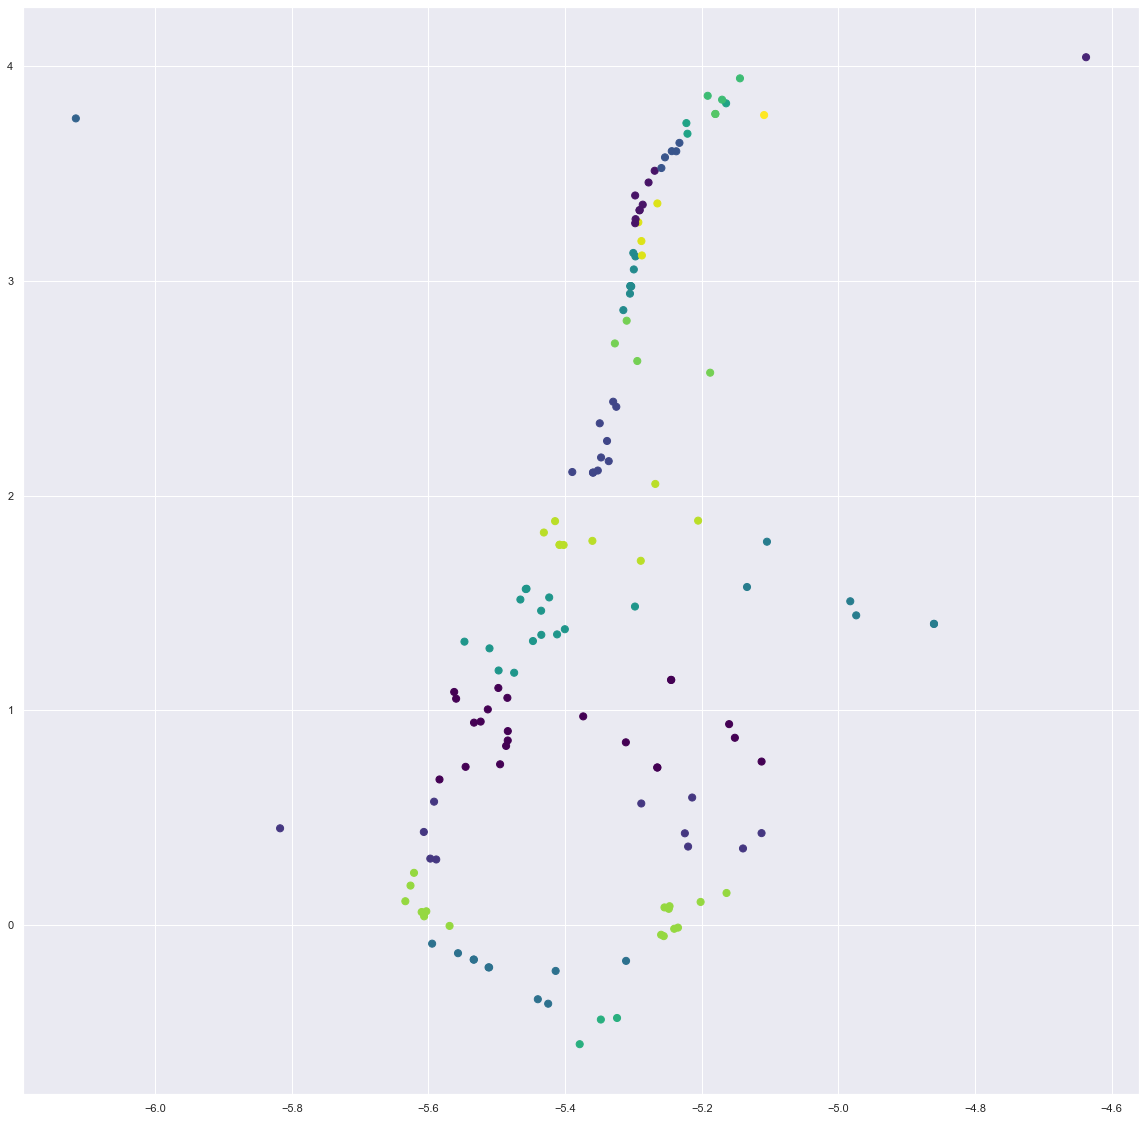

In [270]:
# sklearn
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
# 시각화
import seaborn as sns
import matplotlib.pyplot as plt

# clustering
k = 20
kmeans = KMeans(n_clusters=k, random_state=2021)
y_pred = kmeans.fit_predict(sentence_glove)


# tsne
tsne = TSNE(verbose=1, perplexity=100, random_state=2021)     # perplexity : 유사정도
z = tsne.fit_transform(sentence_glove)

df = pd.DataFrame()
df["y"] = y_pred
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

plt.scatter(z[:,0],z[:,1], c=y_pred, s=50, cmap='viridis')

centers = kmeans.cluster_centers_

In [271]:
index = 0
result = dict()
for i in y_pred:
    #print(i, " : ",check_word[index] )
    if i in result:
        result[i].append(check_word[index])
    else:
        result[i] = [check_word[index]]
    index = index + 1
for i in result:
    print(result[i])
    print('-'*20)

['사용', '번', '대비', '감사', '효과', '굿', '전', '입', '한', '물', '걱정', '약', '포장', '필요']
--------------------
['구매', '송', '데', '각질', '요', '대', '순', '토로', '딸', '의사', '갑']
--------------------
['용량', '가격', '양도', '성비', '피부', '맘', '좋아서', '향도', '평', '크림', '대박', '예', '정도', '다음', '여드름', '정돈']
--------------------
['향', '것', '냄새', '처음', '넘', '중', '상품', '자연', '필']
--------------------
['토너', '쑥', '대용량', '화장', '송도', '주문', '세안', '이', '해', '송이']
--------------------
['거', '부담', '바']
--------------------
['배', '스킨', '클렌징', '느낌', '후', '성분', '기대', '원', '흡수']
--------------------
['향도', '얼굴', '진정', '요', '안', '만족', '편', '기분', '때문', '토']
--------------------
['피부']
--------------------
['만족', '양이', '이번']
--------------------
['가격', '구입', '개', '커서', '용량', '감', '후기', '제품', '니다', '배', '짐승', '상품', '허브', '분', '이랑', '꺼', '미스트', '느낌', '향기', '양', '요즘', '년']
--------------------
['솜', '생각', '수분', '건']
--------------------
['폼', '사은품', '자극', '제거', '냉장고', '레몬']
--------------------
['트러블', '제품', '듯', '팩']
-------------------

In [50]:
# TextRank 중요문장 10개 추출
from textranks.textrank import KeysentenceSummarizer
from konlpy.tag import Komoran

komoran = Komoran()

summarizer = KeysentenceSummarizer(
    tokenize = komoran_tokenizer,
    min_sim = 0.3,
    verbose = False
)


keysents = summarizer.summarize(list(df2)[:], topk=100)


In [51]:

for i in keysents:
    print(i)

(191, 3.8441870295461054, '쑥향 대용량 토너 찾던중에 진정 효과도있다고하여 시켜보았어요  세안후 화장솜으로 피부결정돈할때 사용하고 진정된다하여 화장솜에 적셔서 얼굴에 올려보았습니다생각보다 산뜻한느낌은아니고 살짝 미끌미끌한 촉감이에요 대용량이라 그냥 편하게쓰기좋은것같아요  재구매는 안할것같네요')
(443, 3.824293439318724, '조아용 처음 듣는 브랜드지만 배송도 빠르고 대용량 에 에 클렌징폼까지 딜이 너무 좋네요 사용 전이지만 항상 토너를 많이 써서 주문했어요 향은 진짜 제품명대로 쑥 향이 나요 막 쓰지도 않고 그냥 얼굴에 바르면 피부가 반드시 좋아질것 같은 향이 나요 향에 민감하시거나 거부감 드시는 분들도 쑥차 마시는 기분으로 가볍게 쓰시기 괜찮을것같아요 다 쓰게되면 재구매 할께요 좋은 구성 많이 많이 해주세요')
(175, 3.6000601803629113, '약쑥이라 자연약쑥이 들어가서인지 향이 좋고 마음이 진정되는 느낌입니다 그리고 제 피부가 민감해서 약간 따갑다는 평을 보고 걱정을 했었는데 화한 느낌이 들긴 하지만 따갑거나 하지는 않습니다 눈에 살짝 들어갔는데도 별로 따갑다는 느낌을 못 받았습니다 그리고 용량이 무척 많고 가격도 싸고 거기에 폼클렌징까지 주니까 정말 잘 샀다는 생각이 듭니다 각질 제거까지는 모르겠고 산뜻한 느낌이고 모공도 약간 줄어든 느낌입니다 뚜껑 부분이 커서 많이 흘러나온다는 평이 있었는데 어차피 화장솜에 충분히 적셔서 사용해야 한다고 하면 별로 문제될 것이 없을 것 같습니다 보장도 잘 되어 왔고 배송도 바로 왔습니다 다음에 또 사고 싶습니다')
(169, 3.45490428331076, '좋아요 좋아요  현재 병 거의 다 써가고 있어요 가격 대비 대용량으로 매우 좋구요닥아내는 토너로 한 번 쓰고 번 정도 화장솜에 많이 적셔서 팩처럼 사용하고 있습니다대용량에 가격대비 좋아서 아끼지 않고 펑펑 쓸 수 잇어서 좋구요 쑥향도 좋습니다 지성피부에게 적합해요')
(61, 3.3607319739902293,

1360

1322